In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                            roc_auc_score, balanced_accuracy_score, ConfusionMatrixDisplay)

C:\ProgramData\Anaconda3\envs\xgboost\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# import data
data = pd.read_csv('../data/train_clean.csv')

In [3]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [4]:
data['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [5]:
data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [6]:
# since we're interested in the people who did not get vaccinated: switch 0 and 1 labels
data['h1n1_vaccine'].replace({1:0, 0:1}, inplace=True)
data['h1n1_vaccine'].value_counts()

data['seasonal_vaccine'].replace({1:0, 0:1}, inplace=True)
data['seasonal_vaccine'].value_counts()

1    14272
0    12435
Name: seasonal_vaccine, dtype: int64

**Feature Engineering** : only use top fifteen features

In [7]:
features_to_use = pd.read_csv('../data/XGB_H1N1_feature_imp.csv')

Doctor recommended features

In [8]:
#####
data['doctor_recc_h1n1'].value_counts()

0.0            19139
1.0             5408
no_response     2160
Name: doctor_recc_h1n1, dtype: int64

In [9]:
data['doctor_recc_h1n1'].dtypes

dtype('O')

In [10]:
data['doctor_recc_h1n1'] = data['doctor_recc_h1n1'].replace({'0.0': 1, '1.0': 2, 'no_response': 0})

data['doctor_recc_h1n1'].value_counts()

1    19139
2     5408
0     2160
Name: doctor_recc_h1n1, dtype: int64

In [11]:
#####
data['doctor_recc_seasonal'].value_counts()

0.0            16453
1.0             8094
no_response     2160
Name: doctor_recc_seasonal, dtype: int64

In [12]:
data['doctor_recc_seasonal'] = data['doctor_recc_seasonal'].replace({'0.0': 1, '1.0': 2, 'no_response': 0})
data['doctor_recc_seasonal'].value_counts()

1    16453
2     8094
0     2160
Name: doctor_recc_seasonal, dtype: int64

In [13]:
#####
data['chronic_med_condition'].value_counts()

0.0            18446
1.0             7290
no_response      971
Name: chronic_med_condition, dtype: int64

In [14]:
data['chronic_med_condition'] = data['chronic_med_condition'].replace({'no_response' : 0, '0.0' : 1, '1.0': 2})
data['chronic_med_condition'].value_counts()

1    18446
2     7290
0      971
Name: chronic_med_condition, dtype: int64

In [15]:
#####
data['age_group'].value_counts()

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

In [16]:
data['age_group'].replace({
    '18 - 34 Years' : 0,
    '35 - 44 Years' : 1,
    '45 - 54 Years' : 2,
    '55 - 64 Years' : 3,
    '55 - 64 Years' : 4,
    '65+ Years' : 5
    
}, inplace=True)

data['age_group'].value_counts()

5    6843
4    5563
2    5238
0    5215
1    3848
Name: age_group, dtype: int64

In [17]:
#####

data['health_worker'].value_counts()

no             23004
yes             2899
no_response      804
Name: health_worker, dtype: int64

In [18]:
data['health_worker'].replace({'no_response': 0,'no': 1, 'yes': 2}, inplace=True)
data['health_worker'].value_counts()

1    23004
2     2899
0      804
Name: health_worker, dtype: int64

In [19]:
# make a new feature h1n1_all for participants who had both h1n1_concern and h1n1_knowledge
data[['h1n1_concern', 'h1n1_knowledge']].dtypes

h1n1_concern      float64
h1n1_knowledge    float64
dtype: object

In [20]:
data['h1n1_all'] = data['h1n1_concern'] * data['h1n1_knowledge']

In [21]:
# make a new feature h1n1_all for participants who responded yes to all the behavior questions
behaviour_columns = [column for column in list(data.columns) if 'behavioral' in column]
data[behaviour_columns].dtypes

behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
dtype: object

In [22]:
data['behavioral_all'] = 1

for column in behaviour_columns:
    data['behavioral_all'] = data['behavioral_all'] * data[column]

In [23]:
# make a new feature opinion_all for participants based on their opinion scores to the opinion questions
opinion_columns = [column for column in list(data.columns) if 'opinion' in column]
data[opinion_columns].dtypes

opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
dtype: object

In [24]:
data['opinion_all'] = 1

for column in opinion_columns:
    data['opinion_all'] = data['opinion_all'] * data[column]

In [25]:
# doctor recommended columns
doctor_columns = [column for column in list(data.columns) if 'doctor' in column]

data['doctor_recc_all'] = 1

for column in opinion_columns:
    data['doctor_recc_all'] = data['doctor_recc_all'] * data[column]

In [26]:
# health_worker and age group

data['health_worker_by_age'] = data['health_worker'] * data['age_group']

In [27]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine', 'h1n1_all',
       'behavioral_all', 'opinion_all', 'doctor_recc_all',
       'health_worker_by_age'],
   

**dummify x**

In [28]:
categorical_columns = list(data.select_dtypes('object').columns)
categorical_columns

['health_insurance',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'employment_industry',
 'employment_occupation']

In [29]:
Xd = pd.get_dummies(data=data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine']),
                    columns=categorical_columns, drop_first=True)

**define X and y**

In [30]:
X = Xd[features_to_use['feature']]

In [31]:
y = data['h1n1_vaccine']

In [32]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state=42, stratify=y)

In [33]:
# balance classes

smo = SMOTE(k_neighbors=7, random_state=42)

X_train_over, y_train_over = smo.fit_resample(X_train, y_train)


In [34]:
X_train_over = np.array(X_train_over)
X_test = np.array(X_test)

In [35]:
y_train_over = np.array(y_train_over)
y_test = np.array(y_test)

In [46]:
X.columns

Index(['opinion_h1n1_vacc_effective', 'health_insurance_no_response',
       'opinion_h1n1_risk', 'h1n1_knowledge', 'behavioral_large_gatherings',
       'marital_status_Not Married', 'rent_or_own_Rent',
       'behavioral_touch_face', 'opinion_seas_risk',
       'opinion_seas_vacc_effective', 'education_< 12 Years',
       'behavioral_avoidance', 'doctor_recc_h1n1', 'behavioral_outside_home',
       'household_adults'],
      dtype='object')

**Run model**

In [36]:
xgb_best = xgb.XGBClassifier(random_state=42,
                             use_label_encoder=False,
                             eval_metric='error',
                            booster='gbtree',
                            colsample_bytree=0.9,
                            learning_rate=0.05,
                            max_depth=7,
                            n_estimators=100,
                            subsample=0.5)
xgb_best.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [37]:
test_pred = xgb_best.predict(X_test)
train_pred = xgb_best.predict(X_train)

C:\ProgramData\Anaconda3\envs\xgboost\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


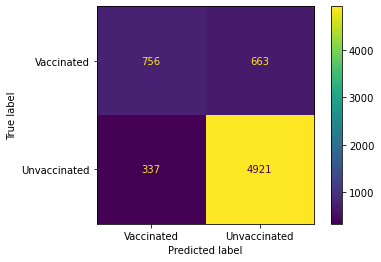

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=['Vaccinated', 'Unvaccinated'])

In [39]:
accuracy_score(y_test, test_pred), accuracy_score(y_train, train_pred)

(0.8502321401827168, 0.8767848227658512)

In [40]:
precision_score(y_test, test_pred)

0.8812679083094556

In [41]:
recall_score(y_test, test_pred)

0.9359071890452644

In [42]:
roc_auc_score(y_test, test_pred)

0.7343383725353172

In [43]:
balanced_accuracy_score(y_test, test_pred)

0.7343383725353172